In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/tjjones93/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [3]:
scripts = pd.read_csv('../public/data/seinfeld_scripts.csv')
ep_info = pd.read_csv('../public/data/episode_info.csv')

season_ids = scripts['SEID'].unique() # numpy.ndarray of SEIDs: ['S01E01', 'S01E02', ... , 'S09E23']


In [4]:
def get_script(SEID):
    ep = scripts[scripts['SEID'] == SEID]

    # create S01E01 DataFrame with columns containing unprocessed dialogue
    # and tokenized dialogue
    d = {
        'dialogue': ep['Dialogue'].to_numpy(),
        'tokens': ep['Dialogue'].apply(sent_tokenize)
    }

    return pd.DataFrame(d)

# get_script('S01E01').head()

In [5]:
def get_comp_scores(SEID):
    
    def comp_scores(line):

    # finds average compound sentiment score
    # compound >= 0.05 == positive
    # compound <= -0.05 == negative
    # 
    # because sentiments can vary wildly from line to line,
    # and the sentiment range is -1 to 1,
    # the function only returns compound scores >= 0.3 or <= -0.3
    # so that we can graph moments in each episode where emotions are most heightened

        comp = 0
        for sent in line:
            comp += analyzer.polarity_scores(line)['compound']
            if round(comp/(len(line)),4) >= 0.15 or round(comp/(len(line)),4) <= -0.15:
                return round(comp/len(line),4)
            else:
                return None

    # create new 'compound' col in S01E01 DataFrame
    SEID['compound'] = SEID['tokens'].apply(comp_scores)
    
    return SEID

# get_comp_scores(get_script('S01E01')).head()

### Calculate affect scores using NRC Lexicon

In [6]:
from nrclex import NRCLex

In [7]:

affects = [
    'fear',
    'anger',
    'anticip',
    'trust',
    'surprise',
    'sadness',
    'disgust',
    'joy'
]

def get_affects(line, affect):
    affect_freqs = NRCLex(line).affect_frequencies
    return affect_freqs[affect]

def get_affect_scores(SEID):
    for affect in affects:
        SEID[affect] = SEID['dialogue'].apply(get_affects, args=(affect,))
    return SEID

#get_affect_scores(get_comp_scores(get_script('S01E01'))).head()

### Save Script Scores as CSV

In [9]:
def save_to_csv(season_ids):
    for season_id in season_ids:
        ep = get_affect_scores(get_comp_scores(get_script(season_id)))
        ep.to_csv(f'./data/{season_id}.csv', index=False)
    

s = ['S01E01', 'S01E02', 'S01E03']
save_to_csv(s)

### Plot Compound Scores of Season 1, Episode 1

In [27]:
plt.rcParams['figure.figsize'] = [25, 5] # makes pandas plot wider [width, height]

<AxesSubplot:>

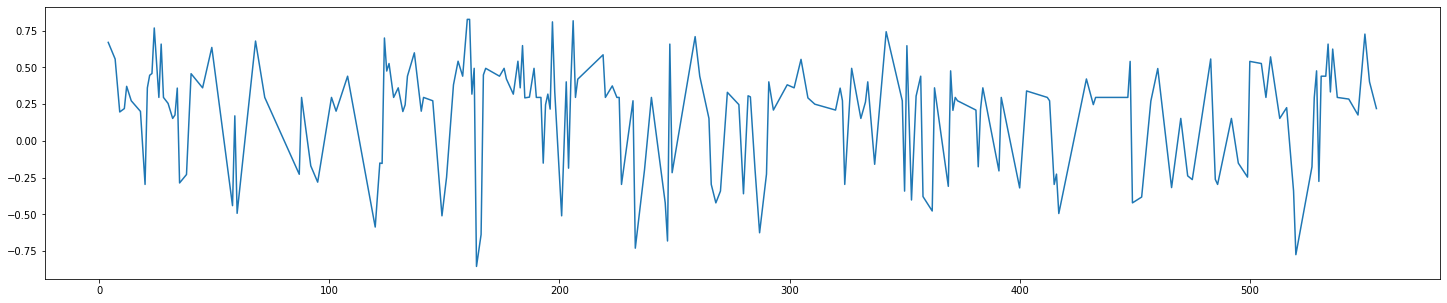

In [50]:
pd.Series(S01E01['compound']).dropna().plot()

### Plot Compound and Affect Scores of Season 1, Episode 1

<AxesSubplot:>

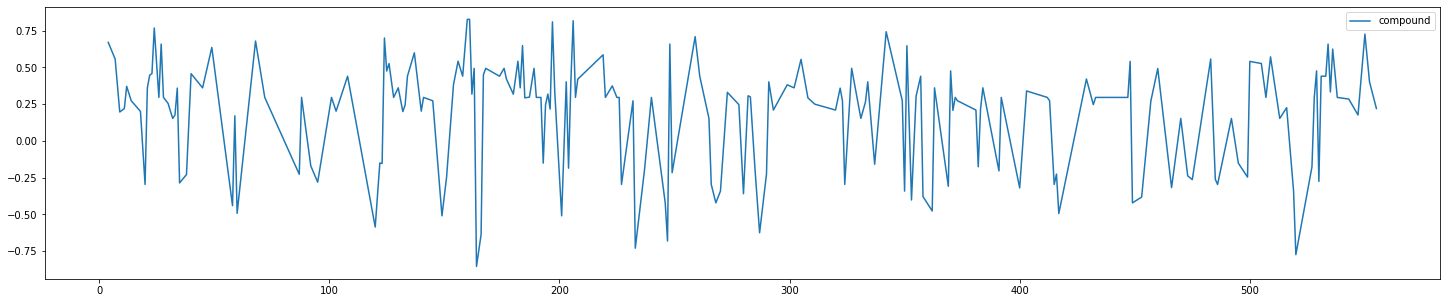

In [51]:
S01E01.dropna().plot()